# Time Series Prediction with LSTM Using PyTorch

datasets:
- [Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)
 - [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

code: https://github.com/spdin/time-series-prediction-lstm-pytorch


In [1]:
from bluer_sandbox import notebooks

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

from bluer_options import string
from bluer_objects import objects, file

from bluer_sandbox.host import signature
from bluer_sandbox.logger import logger

logger.info(f"{'.'.join(signature())},\nbuilt on {string.pretty_date()}")

🌀  bluer_sandbox-5.99.1.bluer_ai-12.144.1.bluer_objects-6.129.1.bluer_options-5.99.1.torch-2.2.2.Python 3.12.9.Darwin 23.6.0..Jupyter-Notebook,
built on 21 May 2025, 11:04:49


In [2]:
object_name = "Time_Series_Prediction_with_LSTM_Using_PyTorch-v2"

dataset = "airline-passengers"
assert dataset in ["airline-passengers", "shampoo"]

assert file.download(
    f"https://raw.githubusercontent.com/jbrownlee/Datasets/master/{dataset}.csv",
    objects.path_of(f"{dataset}.csv", object_name)
)

🌀  bluer_objects.file.functions: https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv -> /Users/kamangir/storage/abcli/Time_Series_Prediction_with_LSTM_Using_PyTorch-v2/airline-passengers.csv


## Data Plot

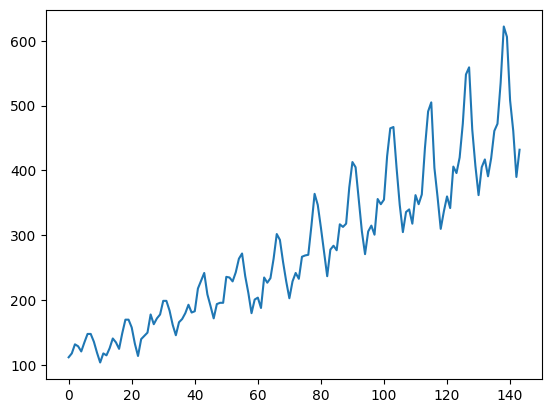

In [3]:
training_set = pd.read_csv(objects.path_of(f"{dataset}.csv", object_name))

training_set = training_set.iloc[:,1:2].values

plt.plot(training_set, label = f'dataset: {dataset}')
plt.show()

## Dataloading

In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [5]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [6]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      logger.info("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

/Users/kamangir/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
🌀  Epoch: 0, loss: 0.09003
🌀  Epoch: 100, loss: 0.01805
🌀  Epoch: 200, loss: 0.00943
🌀  Epoch: 300, loss: 0.00241
🌀  Epoch: 400, loss: 0.00192
🌀  Epoch: 500, loss: 0.00171
🌀  Epoch: 600, loss: 0.00169
🌀  Epoch: 700, loss: 0.00168
🌀  Epoch: 800, loss: 0.00167
🌀  Epoch: 900, loss: 0.00166
🌀  Epoch: 1000, loss: 0.00165
🌀  Epoch: 1100, loss: 0.00164
🌀  Epoch: 1200, loss: 0.00163
🌀  Epoch: 1300, loss: 0.00162
🌀  Epoch: 1400, loss: 0.00162
🌀  Epoch: 1500, loss: 0.00161
🌀  Epoch: 1600, loss: 0.00160
🌀  Epoch: 1700, loss: 0.00159
🌀  Epoch: 1800, loss: 0.00158
🌀  Epoch: 1900, loss: 0.00157


## Test

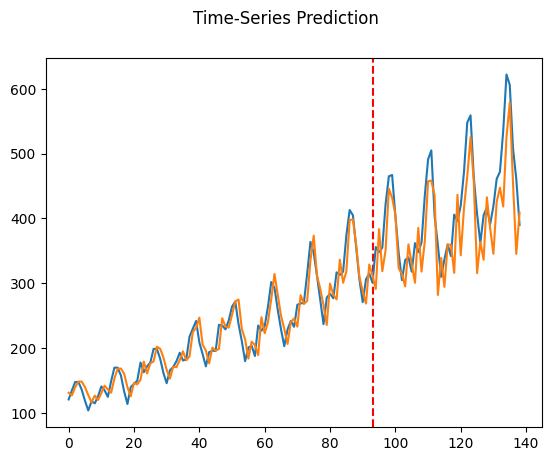

In [7]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [8]:
# END